# Single Cell RNA-seq Workflow for Clustering

* Preprocessing
* Quality Control
* Normalization and Imputation
* Feature Selection (HVGs)
* Dimensionality Reduction (PCA)

In [1]:
# Download data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75688
!python -V
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz

Python 3.10.12
--2024-11-21 13:28:33--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10799212 (10M) [application/x-gzip]
Saving to: ‘GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz’

GSE75688_GEO_proces 100%[===================>]  10.30M  15.1MB/s    in 0.7s    

2024-11-21 13:28:34 (15.1 MB/s) - ‘GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz’ saved [10799212/10799212]

--2024-11-21 13:28:34--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp

In [2]:
# Install scanpy
!pip install --quiet scanpy
!pip install --quiet leidenalg

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 872.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.2 MB/s eta 0:00:00


In [97]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt

In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 pynndescent==0.5.13


In [5]:
results_file = 'write/gse75688.h5ad'

# Reading Data

In [6]:
df_info = pd.read_csv('GSE75688_final_sample_information.txt.gz', sep='\t')
df_info

,sample,type,index,index2,index3
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell
526,BC06_74,SC,Tumor,Tumor,Tumor


In [7]:
df_info['index'].value_counts()

,count
index,
Tumor,326
nonTumor,202


In [8]:
df = pd.read_csv('GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz', sep='\t')
df

,gene_id,gene_name,gene_type,BC01_Pooled,BC01_Tumor,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Pooled,BC05_Pooled,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
0,ENSG00000000003.10,TSPAN6,protein_coding,2.33,1.25,43.96,7.64,9.32,133.37,84.77,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
1,ENSG00000000005.5,TNMD,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSG00000000419.8,DPM1,protein_coding,60.70,28.44,74.73,41.41,87.69,120.41,70.67,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
3,ENSG00000000457.9,SCYL3,protein_coding,47.93,4.43,9.89,7.61,7.32,12.42,12.02,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
4,ENSG00000000460.12,C1orf112,protein_coding,4.79,1.67,10.87,0.92,15.13,17.10,5.69,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57910,ERCC-00170,ERCC-00170,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57911,ERCC-00171,ERCC-00171,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57912,SPIKE1,EC2,SPIKE_IN,14940.70,45728.19,10442.91,94250.71,40823.13,24540.58,12613.85,...,166346.51,54443.35,120842.89,135291.06,138048.60,58840.26,65246.34,33465.11,108901.35,57492.01
57913,SPIKE2,EC15,SPIKE_IN,985.82,607.50,362.55,2949.35,1291.13,854.53,399.57,...,6860.84,2136.69,4048.09,4062.59,4147.05,2286.91,2821.49,1652.19,3439.53,1837.41


## Preparing Annotated Data

### Gene Expression Matrix

In [9]:
samples = df.loc[:,'BC01_02':]
samples

,BC01_02,BC01_03,BC01_04,BC01_05,BC01_06,BC01_08,BC01_10,BC01_11,BC01_12,BC01_24,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
0,0.00,0.00,0.00,0.00,0.00,19.38,0.00,0.00,0.00,0.00,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,50.73,120.46,6.97,180.85,32.09,140.00,38.06,0.00,10.77,0.00,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
3,3.28,0.81,92.23,6.44,59.78,37.75,117.92,0.00,0.00,0.00,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
4,0.00,13.42,0.34,0.26,0.00,0.00,0.67,0.00,0.00,0.00,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57910,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57911,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57912,18414.34,19603.44,28523.94,31210.57,48684.49,26428.35,36442.08,122515.89,57692.19,112417.31,...,166346.51,54443.35,120842.89,135291.06,138048.60,58840.26,65246.34,33465.11,108901.35,57492.01
57913,537.11,653.27,916.42,961.37,2052.48,1056.75,1802.41,4791.14,2292.81,3568.05,...,6860.84,2136.69,4048.09,4062.59,4147.05,2286.91,2821.49,1652.19,3439.53,1837.41


In [10]:
columns = samples.T.columns.values
gene_name_list = list(df['gene_name'])
columns_mapping = dict(zip(columns, gene_name_list))
samples = samples.T.rename(columns=columns_mapping)
samples

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,EC2,EC15,EC18
BC01_02,0.00,0.0,50.73,3.28,0.00,0.0,0.00,9.64,2.87,0.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18414.34,537.11,0.0
BC01_03,0.00,0.0,120.46,0.81,13.42,0.0,0.00,36.36,5.02,1.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19603.44,653.27,0.0
BC01_04,0.00,0.0,6.97,92.23,0.34,0.0,0.00,0.00,108.11,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28523.94,916.42,0.0
BC01_05,0.00,0.0,180.85,6.44,0.26,0.0,0.00,0.00,2.32,0.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31210.57,961.37,0.0
BC01_06,0.00,0.0,32.09,59.78,0.00,0.0,0.33,8.42,52.59,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48684.49,2052.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC11_69,0.00,0.0,0.00,0.27,0.14,0.0,0.00,7.06,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58840.26,2286.91,0.0
BC11_70,0.00,0.0,0.00,0.00,247.69,0.0,0.81,4.49,0.00,53.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65246.34,2821.49,0.0
BC11_78,0.00,0.0,136.07,0.07,22.60,0.0,0.83,0.82,70.26,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33465.11,1652.19,0.0
BC11_81,200.82,0.0,22.03,0.19,11.35,0.0,0.00,4.32,1.12,6.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108901.35,3439.53,0.0


### Cells Metadata

In [11]:
columns_mapping = {
    'index': 'is_tumor',
    'index2': 'system',
    'index3': 'cell_type'
}
cells_metadata = df_info[df_info['type'] == 'SC']
cells_metadata = cells_metadata.rename(columns=columns_mapping)
cells_metadata

,sample,type,is_tumor,system,cell_type
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
522,BC06_43,SC,nonTumor,Stromal,Stromal
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell


In [12]:
sample_names = list(samples.index.values)
labeled = list(cells_metadata['sample'].values)
unlabeled = list(cell for cell in sample_names if cell not in labeled)
print(f'Number of unlabeled samples: {len(unlabeled)}')

Number of unlabeled samples: 34


In [13]:
empty_rows = pd.DataFrame({'sample':sample_names})
empty_rows

,sample
0,BC01_02
1,BC01_03
2,BC01_04
3,BC01_05
4,BC01_06
...,...
544,BC11_69
545,BC11_70
546,BC11_78
547,BC11_81


In [14]:
cells_metadata = empty_rows.merge(cells_metadata, how='left', on='sample')
cells_metadata

,sample,type,is_tumor,system,cell_type
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
544,BC11_69,SC,Tumor,Tumor,Tumor
545,BC11_70,SC,Tumor,Tumor,Tumor
546,BC11_78,SC,Tumor,Tumor,Tumor
547,BC11_81,SC,Tumor,Tumor,Tumor


In [15]:
cells_metadata = cells_metadata.set_index(cells_metadata['sample'])
cells_metadata.head(10)

,sample,type,is_tumor,system,cell_type
sample,,,,,
BC01_02,BC01_02,SC,Tumor,Tumor,Tumor
BC01_03,BC01_03,SC,Tumor,Tumor,Tumor
BC01_04,BC01_04,SC,Tumor,Tumor,Tumor
BC01_05,BC01_05,SC,Tumor,Tumor,Tumor
BC01_06,BC01_06,SC,Tumor,Tumor,Tumor
BC01_08,BC01_08,SC,Tumor,Tumor,Tumor
BC01_10,BC01_10,SC,Tumor,Tumor,Tumor
BC01_11,BC01_11,NaN,NaN,NaN,NaN
BC01_12,BC01_12,SC,Tumor,Tumor,Tumor


### Genes Metadata

In [16]:
genes_metadata = df[['gene_id', 'gene_name', 'gene_type']].set_index('gene_name')
genes_metadata

,gene_id,gene_type
gene_name,,
TSPAN6,ENSG00000000003.10,protein_coding
TNMD,ENSG00000000005.5,protein_coding
DPM1,ENSG00000000419.8,protein_coding
SCYL3,ENSG00000000457.9,protein_coding
C1orf112,ENSG00000000460.12,protein_coding
...,...,...
ERCC-00170,ERCC-00170,ERCC
ERCC-00171,ERCC-00171,ERCC
EC2,SPIKE1,SPIKE_IN


In [17]:
print(samples.shape)
print(cells_metadata.shape)
print(genes_metadata.shape)

(549, 57915)
(549, 5)
(57915, 2)


In [18]:
adata = ad.AnnData(samples, obs=cells_metadata, var=genes_metadata)
#adata = ad.AnnData(samples)
adata

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 549 × 57915
    obs: 'sample', 'type', 'is_tumor', 'system', 'cell_type'
    var: 'gene_id', 'gene_type'

In [19]:
adata.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'ERCC-00162', 'ERCC-00163', 'ERCC-00164', 'ERCC-00165', 'ERCC-00168',
       'ERCC-00170', 'ERCC-00171', 'EC2', 'EC15', 'EC18'],
      dtype='object', name='gene_name', length=57915)

In [20]:
adata.obs_names

Index(['BC01_02', 'BC01_03', 'BC01_04', 'BC01_05', 'BC01_06', 'BC01_08',
       'BC01_10', 'BC01_11', 'BC01_12', 'BC01_24',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', name='sample', length=549)

In [21]:
adata.var_names_make_unique()

/usr/local/lib/python3.10/dist-packages/anndata/utils.py:264: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-4', 'SNORD113-5']
  warnings.warn(


In [22]:
adata.X

array([[0.0000000e+00, 0.0000000e+00, 5.0730000e+01, ..., 1.8414340e+04,
        5.3711000e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.2046000e+02, ..., 1.9603440e+04,
        6.5327000e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.9700000e+00, ..., 2.8523940e+04,
        9.1642000e+02, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.3607000e+02, ..., 3.3465110e+04,
        1.6521900e+03, 0.0000000e+00],
       [2.0082000e+02, 0.0000000e+00, 2.2030000e+01, ..., 1.0890135e+05,
        3.4395300e+03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.0458000e+02, ..., 5.7492010e+04,
        1.8374100e+03, 0.0000000e+00]])

In [23]:
adata.var

,gene_id,gene_type
gene_name,,
TSPAN6,ENSG00000000003.10,protein_coding
TNMD,ENSG00000000005.5,protein_coding
DPM1,ENSG00000000419.8,protein_coding
SCYL3,ENSG00000000457.9,protein_coding
C1orf112,ENSG00000000460.12,protein_coding
...,...,...
ERCC-00170,ERCC-00170,ERCC
ERCC-00171,ERCC-00171,ERCC
EC2,SPIKE1,SPIKE_IN


In [24]:
adata.obs

,sample,type,is_tumor,system,cell_type
sample,,,,,
BC01_02,BC01_02,SC,Tumor,Tumor,Tumor
BC01_03,BC01_03,SC,Tumor,Tumor,Tumor
BC01_04,BC01_04,SC,Tumor,Tumor,Tumor
BC01_05,BC01_05,SC,Tumor,Tumor,Tumor
BC01_06,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
BC11_69,BC11_69,SC,Tumor,Tumor,Tumor
BC11_70,BC11_70,SC,Tumor,Tumor,Tumor
BC11_78,BC11_78,SC,Tumor,Tumor,Tumor


# Preprocessing

normalizing counts per cell
    finished (0:00:00)


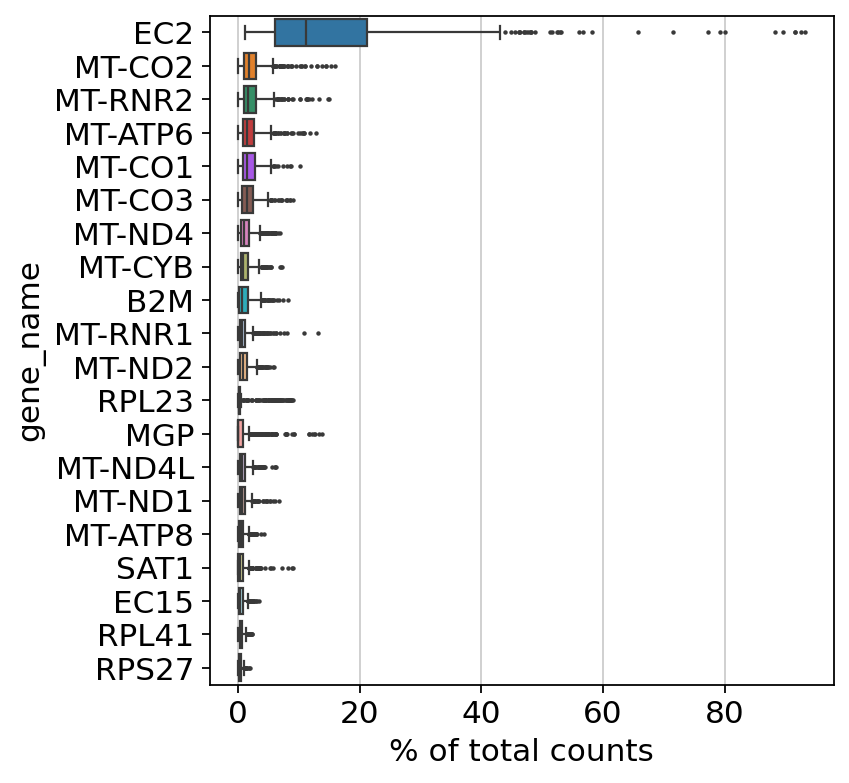

In [25]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [26]:
# Filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 29881 genes that are detected in less than 3 cells


In [27]:
# QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

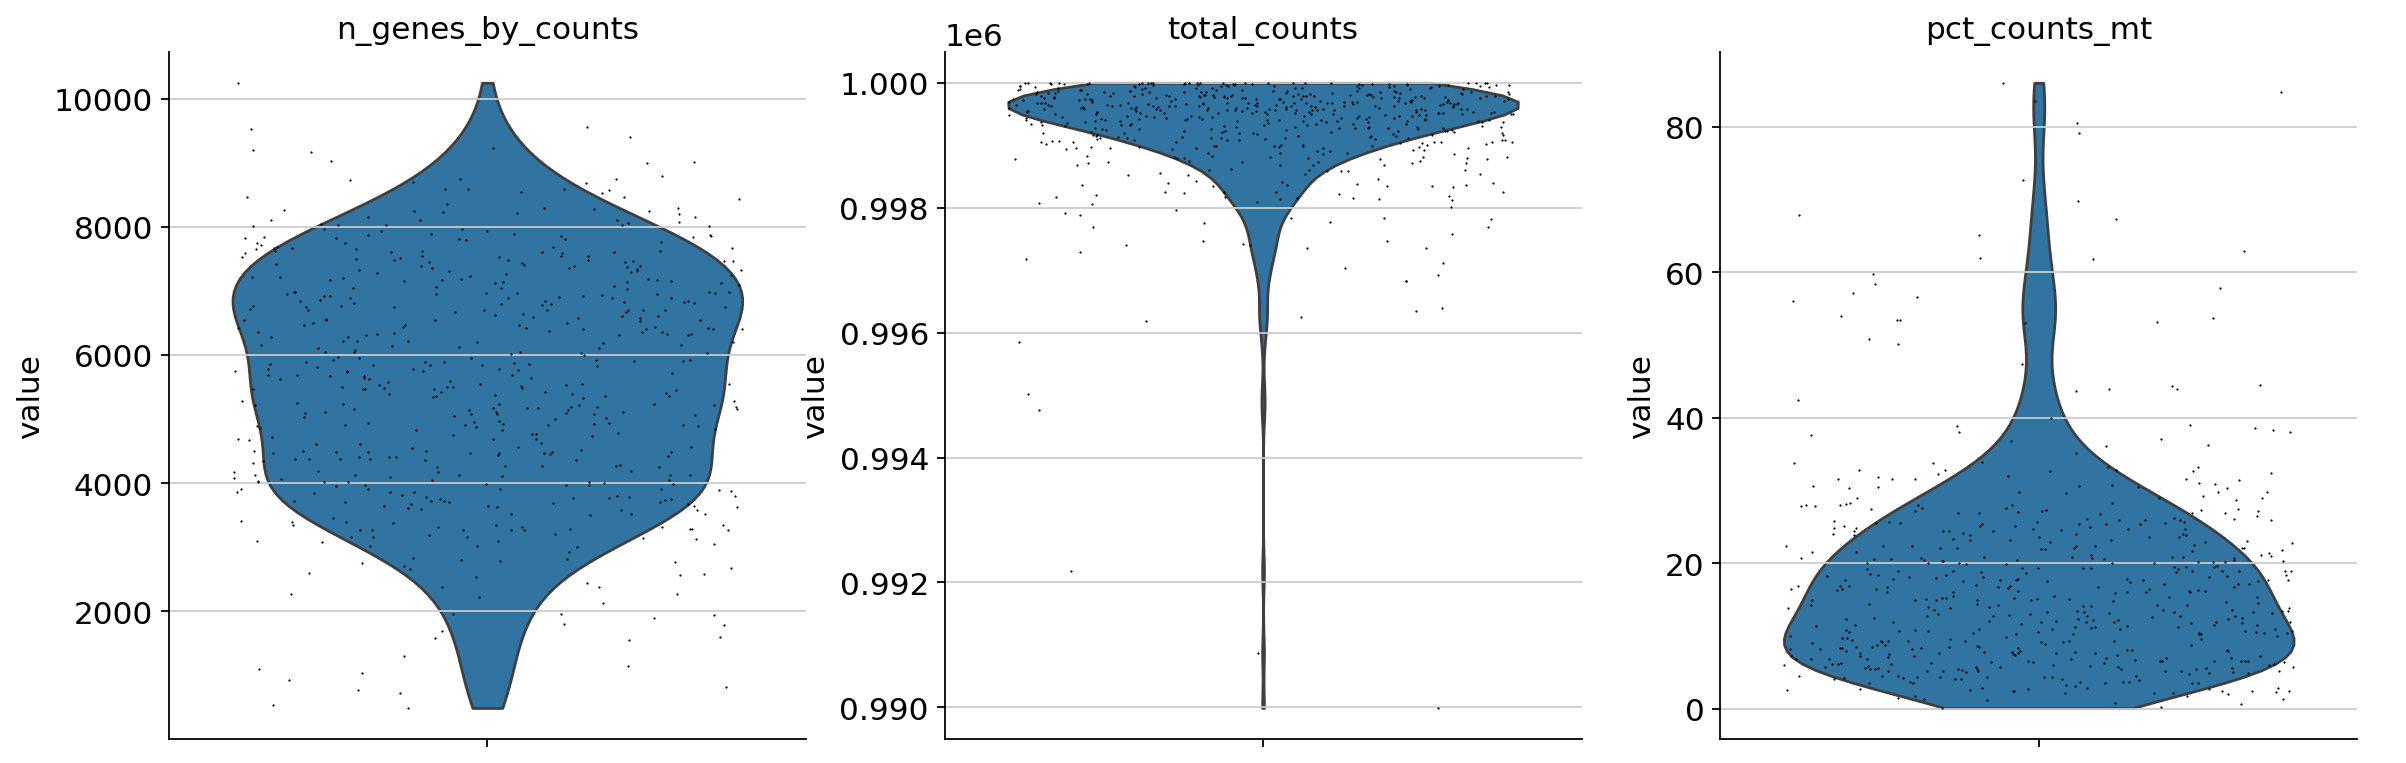

In [28]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

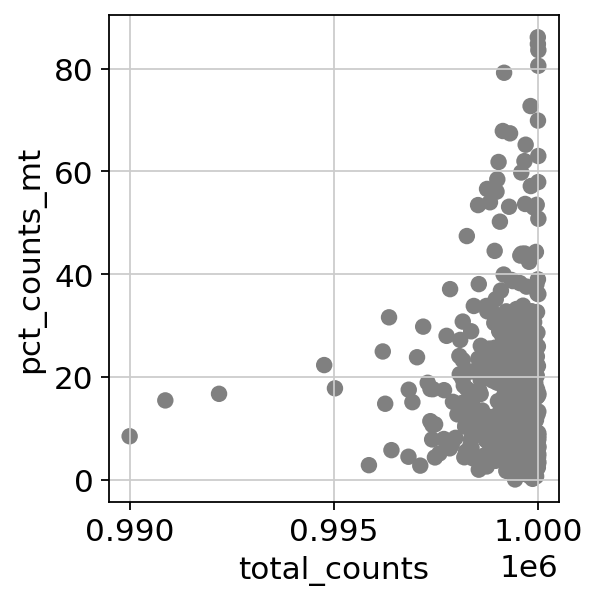

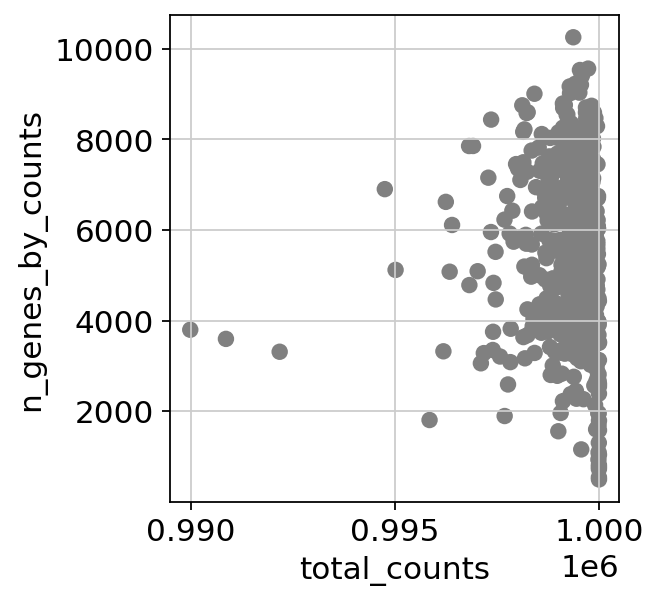

In [29]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [30]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [31]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [32]:
sc.pp.log1p(adata)

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


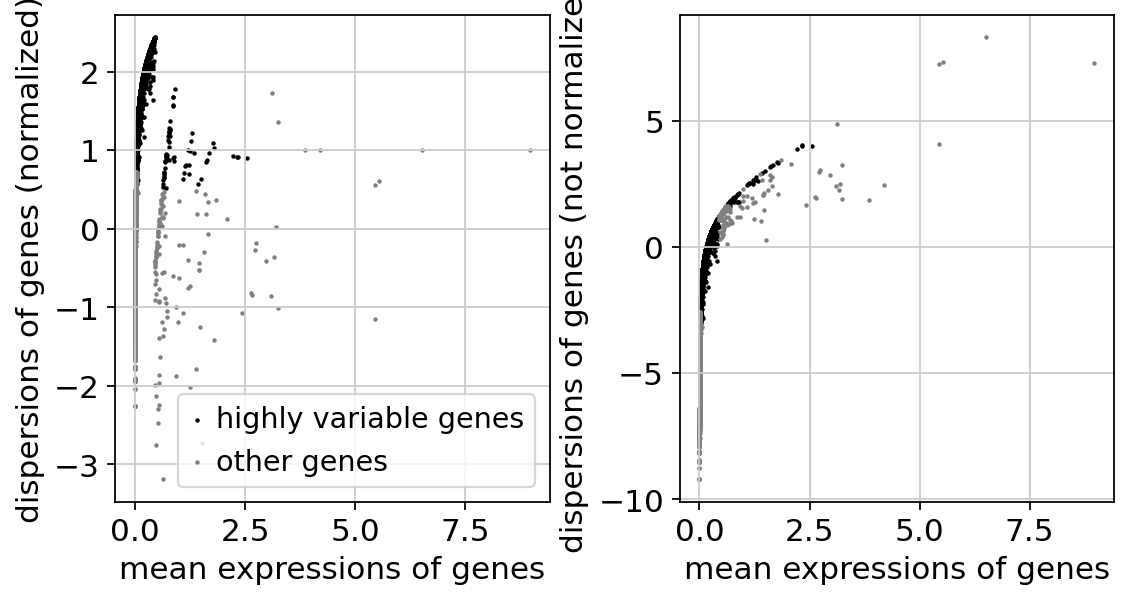

In [34]:
sc.pl.highly_variable_genes(adata)

In [35]:
adata.raw = adata

In [36]:
adata = adata[:, adata.var.highly_variable]

In [37]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:672: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:04)


In [38]:
sc.pp.scale(adata, max_value=10)

In [39]:
dir(adata)

['T',
 'X',
 '_BACKED_ATTRS',
 '_H5_ALIASES',
 '_H5_ALIASES_NAMES',
 '_X',
 '__annotations__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adata_ref',
 '_check_dimensions',
 '_check_uniqueness',
 '_clean_up_old_format',
 '_gen_repr',
 '_get_X',
 '_get_and_delete_multicol_field',
 '_get_obs_array',
 '_get_var_array',
 '_has_X',
 '_init_as_actual',
 '_init_as_view',
 '_inplace_subset_obs',
 '_inplace_subset_var',
 '_is_view',
 '_layers',
 '_mutated_copy',
 '_normalize_indices',
 '_obs',
 '_obsm',
 '_obsp',
 '_oidx',
 '_prep_dim_index',
 '_raw',
 '_remove_unused_categories',
 '_sanitize',
 

In [40]:
adata.T.obs

,gene_id,gene_type,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_name,,,,,,,,,,,,,,
LAS1L,ENSG00000001497.12,protein_coding,250,False,250,14.991439,54.462659,8230.30,True,0.014018,-2.468629,0.778202,3.689179e-16,0.020016
LAP3,ENSG00000002549.8,protein_coding,410,False,410,92.391421,25.318761,50722.89,True,0.196546,-1.606384,1.166228,1.479835e-14,0.123847
HS3ST1,ENSG00000002587.5,protein_coding,52,False,52,0.502332,90.528233,275.78,True,0.037497,-1.472937,1.226282,-2.277287e-14,0.006586
RBM5,ENSG00000003756.12,protein_coding,423,False,423,106.024335,22.950820,58207.36,True,0.018194,-2.262711,0.870869,1.401078e-15,0.035337
FKBP4,ENSG00000004478.5,protein_coding,370,False,370,40.346995,32.604736,22150.50,True,0.024416,-1.908518,1.030262,3.877685e-15,0.054393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-500M8.7,ENSG00000272921.1,protein_coding,300,False,300,29.196831,45.355191,16029.06,True,0.135840,-0.135828,1.828007,1.650532e-14,0.215646
CTD-2303H24.2,ENSG00000273018.1,processed_transcript,94,False,94,7.688852,82.877960,4221.18,True,0.015423,-2.372443,0.821487,1.539278e-15,0.030638
RP11-290D2.6,ENSG00000273149.1,antisense,55,False,55,1.263406,89.981785,693.61,True,0.061059,-0.973476,1.451049,-3.123890e-14,0.010225


In [41]:
type(adata.X)

numpy.ndarray

In [42]:
np.min(adata.X)

-1.9265114996576587

In [43]:
np.max(adata.X)

1.9667266407198702

## PCA

In [44]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=5
    finished (0:00:00)


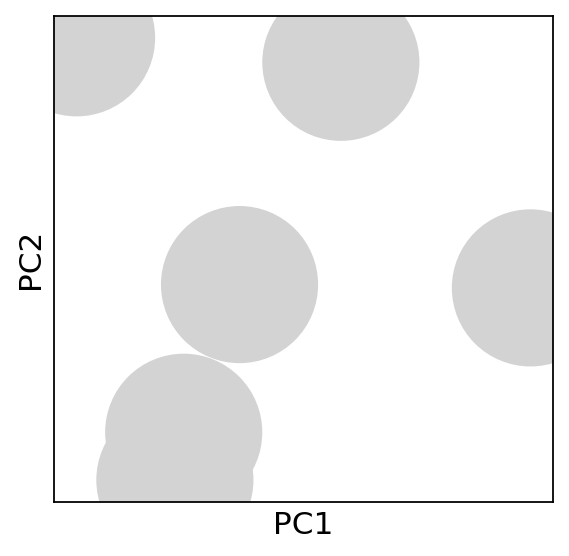

In [45]:
sc.pl.pca(adata)

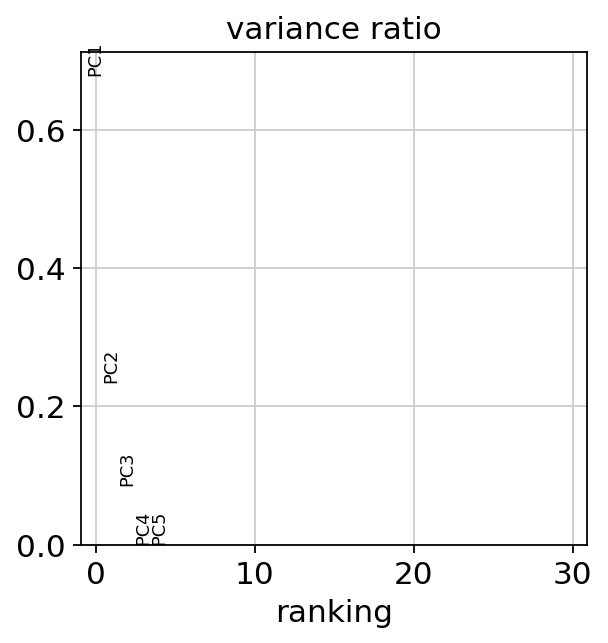

In [46]:
# TODO - This is where the error occurs
sc.pl.pca_variance_ratio(adata, log=False)



In [47]:
results_file

'write/gse75688.h5ad'

In [53]:
# Saving results
adata.write(results_file)

In [54]:
adata

AnnData object with n_obs × n_vars = 6 × 1607
    obs: 'sample', 'type', 'is_tumor', 'system', 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_id', 'gene_type', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing Neighborhood Graph

In [55]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=4)

computing neighbors
    using 'X_pca' with n_pcs = 4
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


In [56]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [57]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)


In [58]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


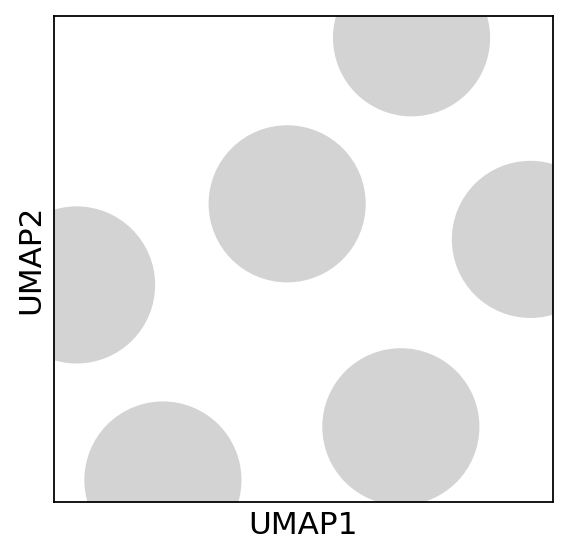

In [59]:
sc.pl.umap(adata)

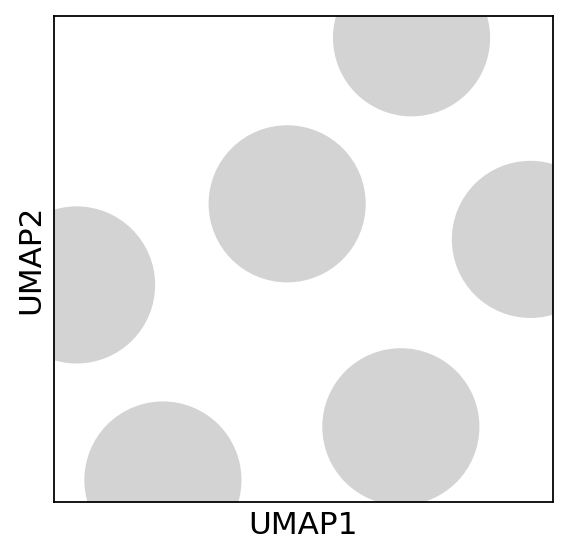

In [60]:
sc.pl.umap(adata, use_raw=False)

### Clustering the neighborhood graph

In [61]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


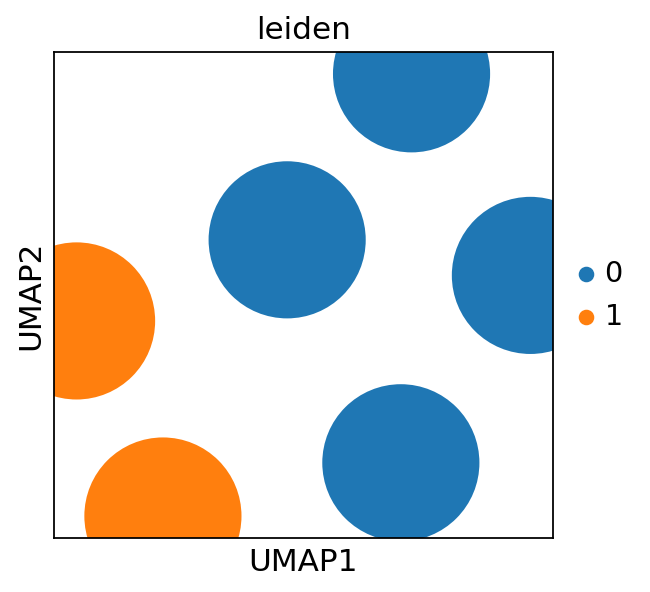

In [62]:
sc.pl.umap(adata, color=['leiden'])

In [63]:
adata.var.index.name = None
adata.write(results_file)

## Filtering marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


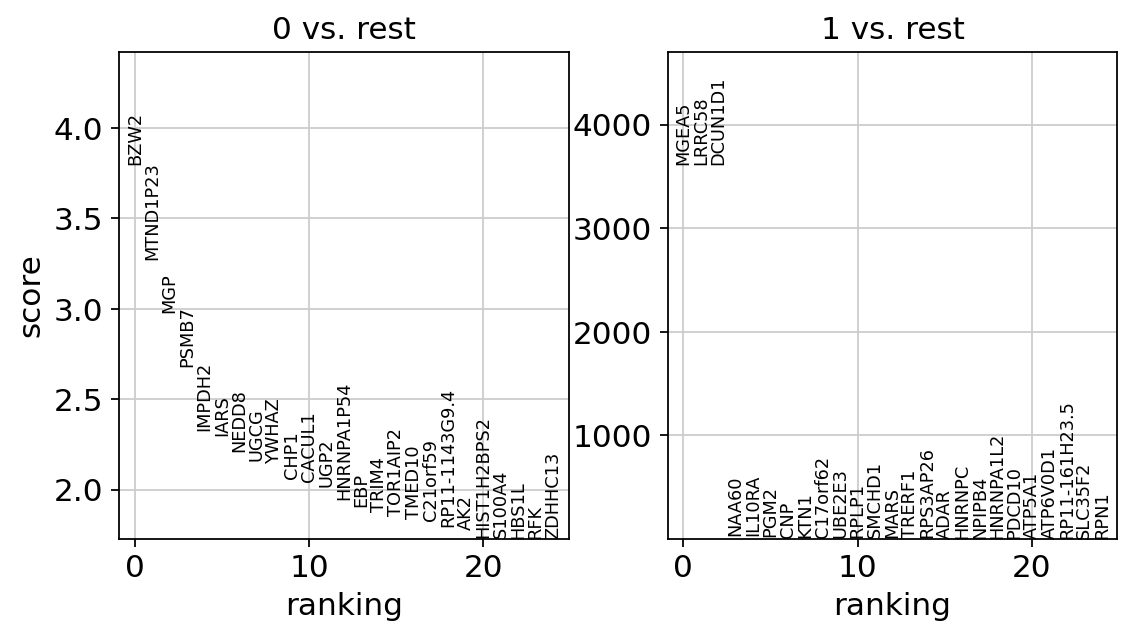

In [64]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [65]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:00)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:446: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(ymin, ymax)


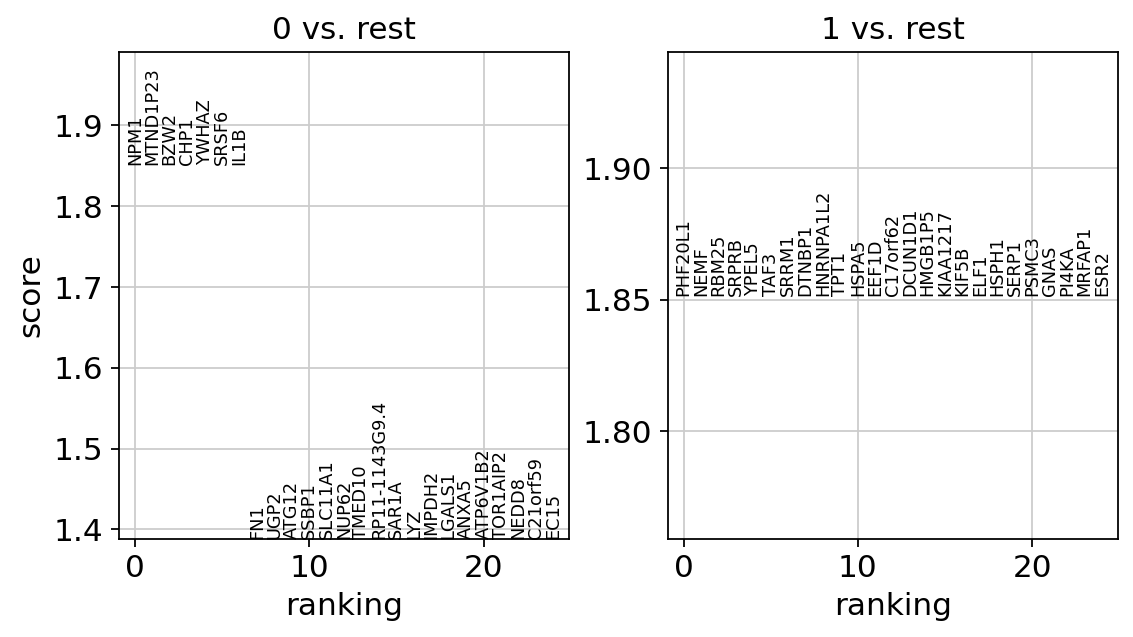

In [66]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [67]:
adata.write(results_file)

ranking genes
    finished (0:00:00)


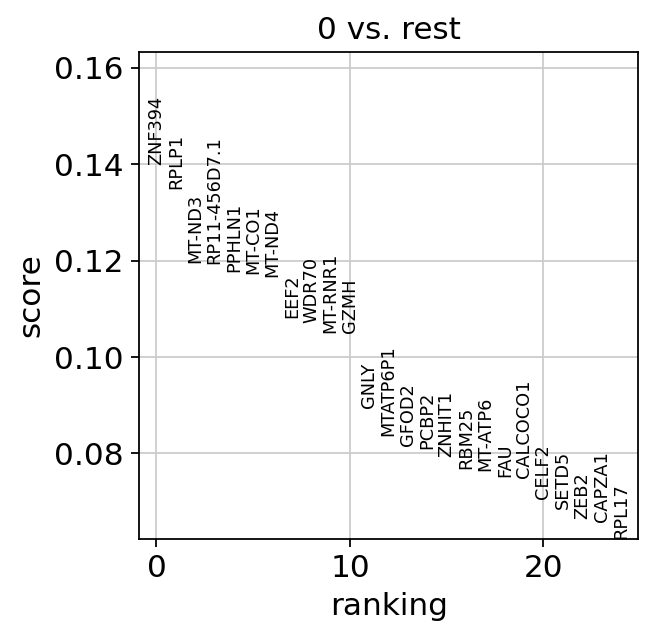

In [68]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [82]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3']

In [83]:
adata = sc.read(results_file)

In [84]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1
0,NPM1,PHF20L1
1,MTND1P23,NEMF
2,BZW2,RBM25
3,CHP1,SRPRB
4,YWHAZ,YPEL5


In [85]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p
0,NPM1,0.064078,PHF20L1,0.064078
1,MTND1P23,0.064078,NEMF,0.064078
2,BZW2,0.064078,RBM25,0.064078
3,CHP1,0.064078,SRPRB,0.064078
4,YWHAZ,0.064078,YPEL5,0.064078


ranking genes
    finished (0:00:00)


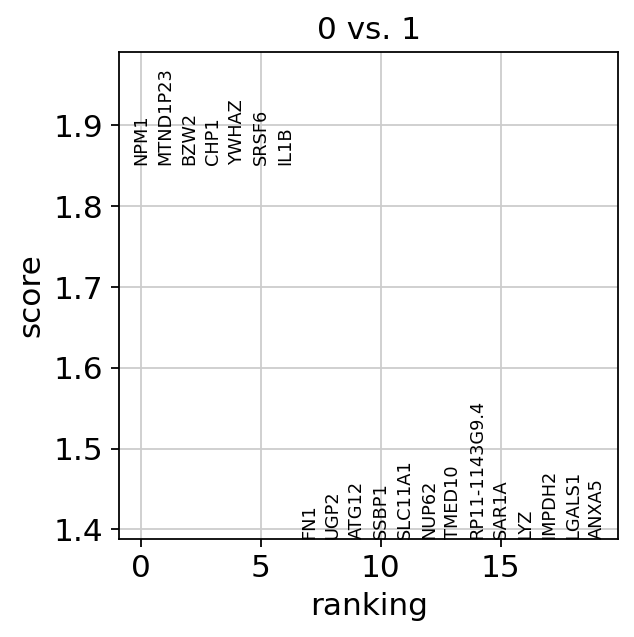

In [86]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


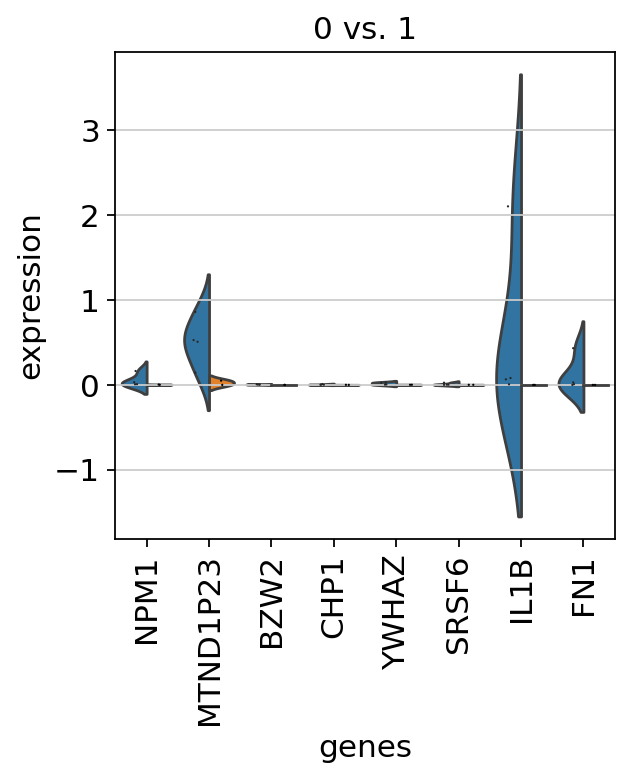

In [87]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [88]:
adata = sc.read(results_file)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/__init__.py:1314: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


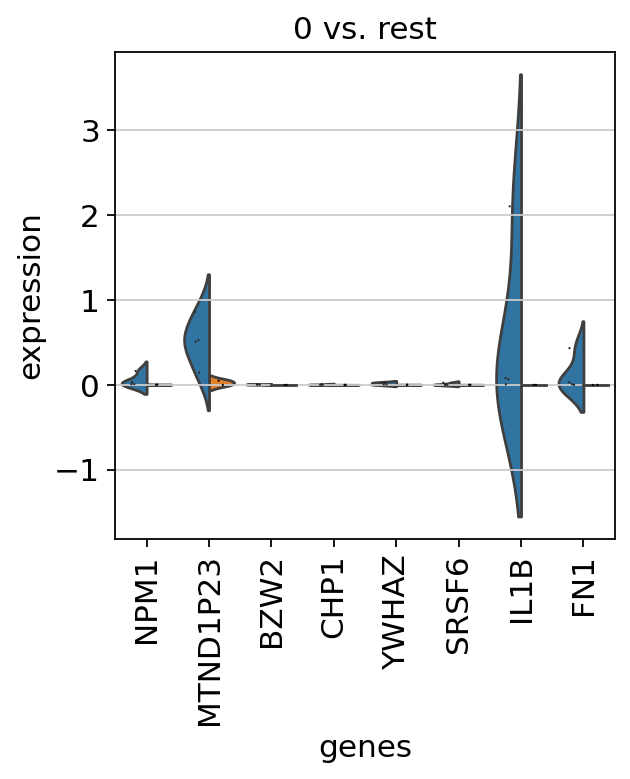

In [89]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

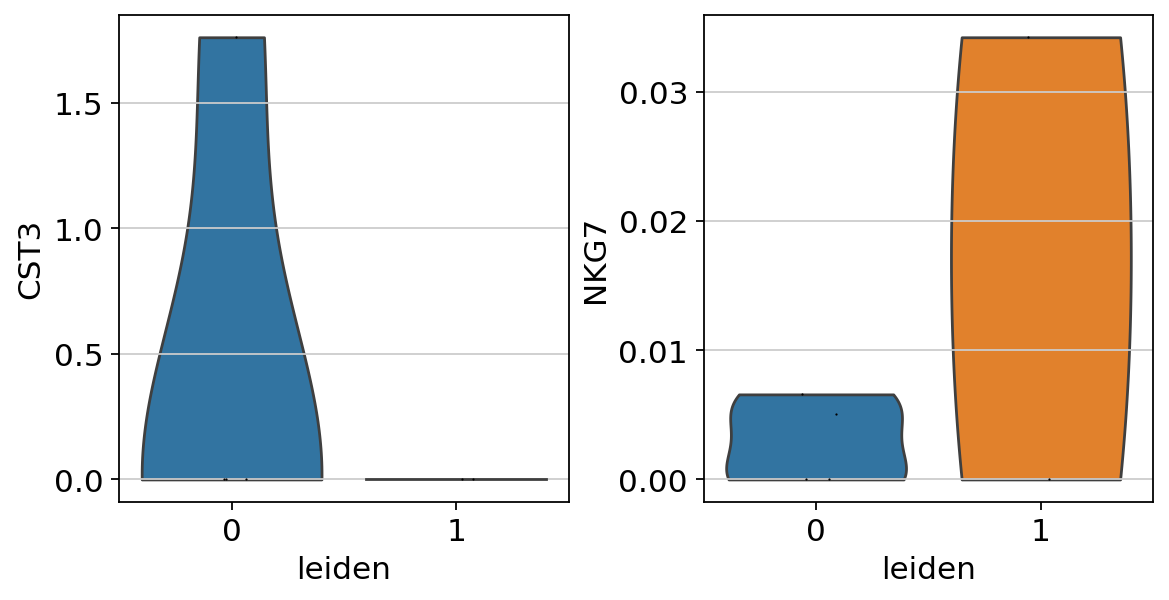

In [90]:
sc.pl.violin(adata, ['CST3', 'NKG7'], groupby='leiden')

In [91]:
new_cluster_names = ['CD4 T', 'CD14 Monocytes']
adata.rename_categories('leiden', new_cluster_names)

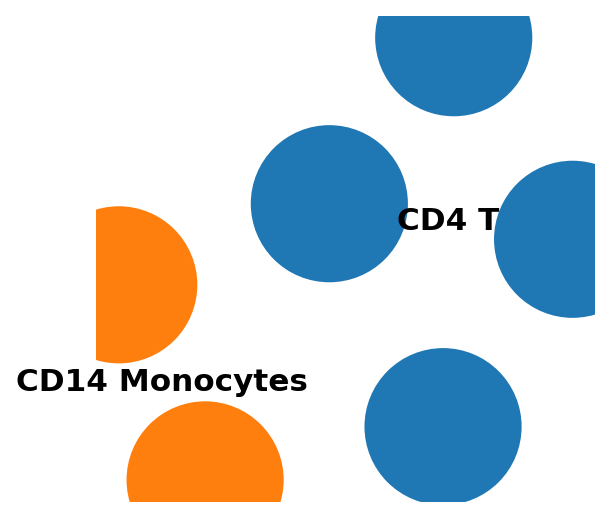

In [92]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

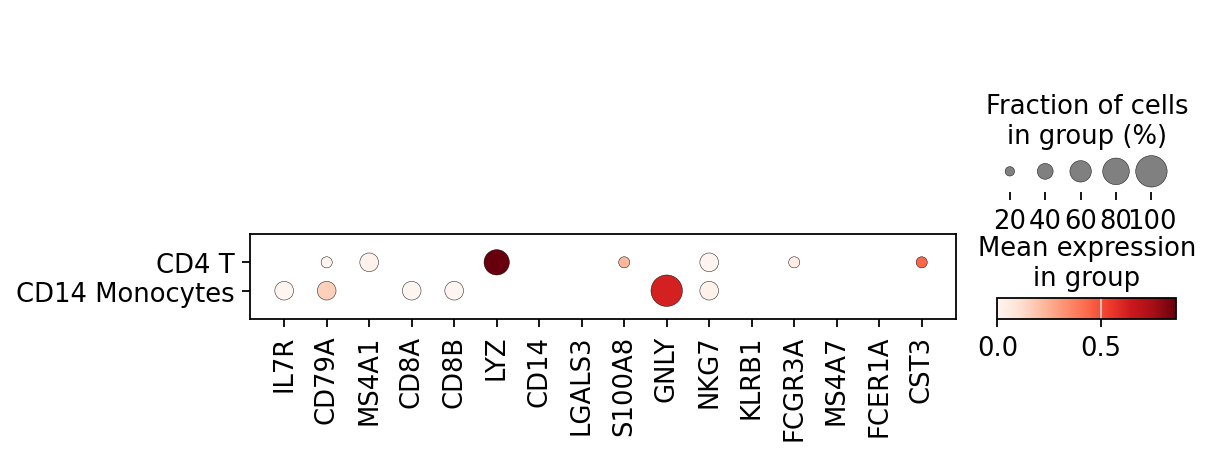

In [93]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

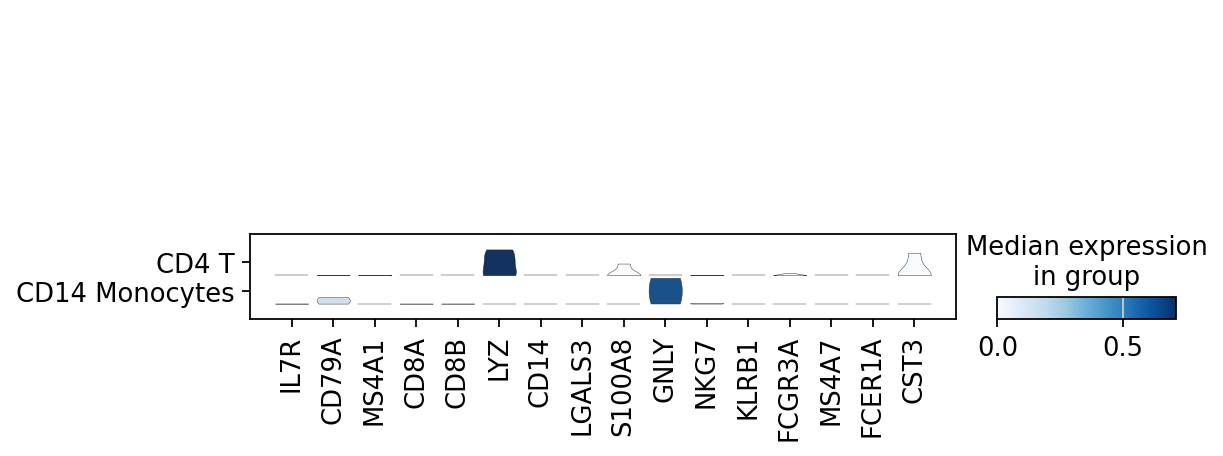

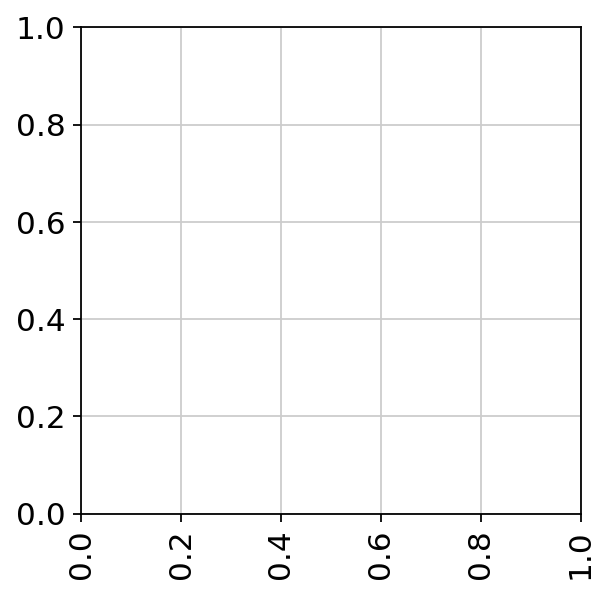

In [99]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden')
plt.xticks(rotation=90)
plt.show()

In [100]:
adata

AnnData object with n_obs × n_vars = 6 × 1607
    obs: 'sample', 'type', 'is_tumor', 'system', 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_id', 'gene_type', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [101]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [102]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [103]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )